In [331]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [210]:
import os
from pycocotools.coco import COCO

# initialize COCO API for instance annotations
dataDir = '.'
dataType = 'val2014'
instances_annFile = os.path.join(dataDir, 'COCO/annotations_trainval2014/annotations/instances_train2014.json'.format(dataType))
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = os.path.join(dataDir, 'COCO/annotations_trainval2014/annotations/captions_train2014.json'.format(dataType))
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=13.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.91s)
creating index...
index created!


{'license': 1, 'file_name': 'COCO_train2014_000000037015.jpg', 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000037015.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-14 18:47:26', 'flickr_url': 'http://farm9.staticflickr.com/8124/8647260855_11247ab35a_z.jpg', 'id': 37015}
http://images.cocodataset.org/train2014/COCO_train2014_000000037015.jpg


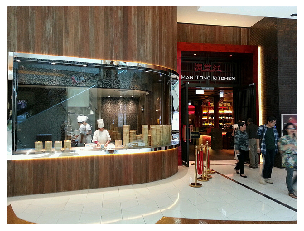

Chefs are preparing food at a restaurant as patrons exit.
A chef is cooking at the counter in front of a restaurant.
The view shows two young people and  a woman leaving an elaborate entry way that includes a curved wall and window, revealing chefs at work,
a restaurant that features a window to see the chefs cooking. 
Several people walking outside of an Asian restaurant.


In [211]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
print(img)
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [212]:
# preprocesing training data
def preProcessData(filename):
    lines = list()
    for i in range(0, len(ids)):
        ann_id = ids[i]
        img_id = coco.anns[ann_id]['image_id']
        img = coco.loadImgs(img_id)[0]
        name = img['file_name']
        annIds = coco_caps.getAnnIds(imgIds=img['id'])
        for j in range(0, len(annIds)):
            lines.append(name + "#" + str(j) + ' ' + coco_caps.loadAnns(annIds[j])[0]['caption'])
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [213]:
preProcessData('COCO/COCO_token.txt')

In [214]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

filename = "COCO/COCO_token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:600])

COCO_train2014_000000480023.jpg#0 A hand holding a hot dog in a paper container covered in mustard and ketchup.
COCO_train2014_000000480023.jpg#1 A person holding a hot dog with yellow mustard and onions on it, at a sports stadium.
COCO_train2014_000000480023.jpg#2 A hand holds a traditional loaded ballgame hotdog.
COCO_train2014_000000480023.jpg#3 A person holding up a hot dog at a ball park.
COCO_train2014_000000480023.jpg#4 A close-up of a person holding hot dog to the camera.
COCO_train2014_000000050518.jpg#0 The young man smiles as he holds a chilli dog.
COCO_train2014_000000050518.jpg#1 


In [215]:
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        if image_desc in mapping[image_id]:
            continue
        # store description
        mapping[image_id].append(image_desc)
    return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 82105 


In [216]:
list(descriptions.keys())[:5]

['COCO_train2014_000000480023',
 'COCO_train2014_000000050518',
 'COCO_train2014_000000142589',
 'COCO_train2014_000000209263',
 'COCO_train2014_000000015307']

In [217]:
descriptions['COCO_train2014_000000050518']

['The young man smiles as he holds a chilli dog.',
 'A man eats food at a bench in front of a boat.',
 'A man eating at a picnic table near a boat dock.',
 'A man smiles and holds a hot dog at a picnic table by a marina.',
 'Dude in shades sits and eats a hotdog']

In [218]:
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [219]:
descriptions['COCO_train2014_000000050518']

['the young man smiles as he holds chilli dog',
 'man eats food at bench in front of boat',
 'man eating at picnic table near boat dock',
 'man smiles and holds hot dog at picnic table by marina',
 'dude in shades sits and eats hotdog']

In [220]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 24042


In [221]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'COCO/descriptions.txt')

In [222]:
# load a pre-defined list of photo identifiers
def load_set():
    dataset = list()
    for i in range(0, len(ids)):
        ann_id = ids[i]
        img_id = coco.anns[ann_id]['image_id']
        img = coco.loadImgs(img_id)[0]
        name = img['file_name'].split('.')[0]
        dataset.append(name)
    return set(dataset)

# load training dataset
train_images = load_set()
print('Dataset: %d' % len(train_images))

Dataset: 82081


In [223]:
# Below path contains all the images
trainImages = 'COCO/train2014/'
# Create a list of all image names in the directory
img = glob.glob(trainImages + '*.jpg')

In [317]:
img2 = list()
for i in train_images:
    img2.append('COCO/train2014/' + i + '.jpg')

In [323]:
img2[0]

'COCO/train2014/COCO_train2014_000000210097.jpg'

In [224]:
img[0]

'COCO/train2014/COCO_train2014_000000516834.jpg'

In [225]:
# Below path contains all the images
testImages = 'COCO/test2014/'
# Create a list of all image names in the directory
img1 = glob.glob(testImages + '*.jpg')

In [226]:
img1[0]

'COCO/test2014/COCO_test2014_000000105361.jpg'

In [227]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('COCO/descriptions.txt', train_images)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=82081


In [228]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [229]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [230]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [231]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [232]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for i in img:
    encoding_train[i[len(trainImages):]] = encode(i)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 3770.6349935531616


In [233]:
import pickle
from pickle import dump, load

In [234]:
# Save the bottleneck train features to disk
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
# Save the bottleneck train features to disk
with open("encoded_train_images2.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train2, encoded_pickle)

In [ ]:
train_features2 = load(open("encoded_train_images2.pkl", "rb"))
print('Photos: train=%d' % len(train_features2))

In [235]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for i in img1:
    encoding_test[i[len(testImages):]] = encode(i)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 1517.816605091095


In [236]:
# Save the bottleneck test features to disk
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [237]:
train_features = load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=82783


In [238]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

410470

In [239]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 24044 -> 6254


In [240]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [241]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

6255

In [242]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 49


In [310]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [244]:
# Load Glove vectors
glove_dir = 'glove.6B'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [245]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [246]:
embedding_matrix.shape

(6255, 200)

In [247]:
# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [248]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 49)           0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 49, 200)      1251000     input_10[0][0]                   
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 2048)         0           input_9[0][0]                    
____________________________________________________________________________________________

In [249]:
model.layers[2]

In [250]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [251]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [252]:
print(len(train_descriptions))

82081


In [253]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [294]:
train_features['COCO_train2014_000000480023.jpg']

array([0.17884976, 1.29116   , 0.03399603, ..., 0.36515495, 0.23914994,
       0.5054868 ], dtype=float32)

In [273]:
train_descriptions['COCO_train2014_000000018377']

['startseq woman with square pizza on metal pan endseq',
 'startseq square pizza is on tray in womans lap endseq',
 'startseq seated woman using spatula to lift square pizza from pan endseq',
 'startseq the lady is sitting on chair with pizza in her lap endseq',
 'startseq woman cutting square pizza and sitting outside endseq']

In [256]:
print(len(train_descriptions), len(train_features))

82081 82783


In [264]:
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
model.fit_generator(generator, epochs=50, steps_per_epoch=steps, verbose=1)

Epoch 1/50
27360/27360 [==============================] - 2133s 78ms/step - loss: 3.2850
Epoch 2/50
27360/27360 [==============================] - 2106s 77ms/step - loss: 3.2687
Epoch 3/50
27360/27360 [==============================] - 2104s 77ms/step - loss: 3.2611
Epoch 4/50
27360/27360 [==============================] - 2106s 77ms/step - loss: 3.2550
Epoch 5/50
27360/27360 [==============================] - 2106s 77ms/step - loss: 3.2581
Epoch 6/50
27360/27360 [==============================] - 2108s 77ms/step - loss: 3.2712
Epoch 7/50
27360/27360 [==============================] - 2108s 77ms/step - loss: 3.2765
Epoch 8/50
27360/27360 [==============================] - 2106s 77ms/step - loss: 3.2892
Epoch 9/50
27360/27360 [==============================] - 2105s 77ms/step - loss: 3.3023
Epoch 10/50
27360/27360 [==============================] - 2105s 77ms/step - loss: 3.2990
Epoch 11/50
27360/27360 [==============================] - 2106s 77ms/step - loss: 3.2954
Epoch 12/50
27360/2

In [265]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [312]:
def greedySearch(photo):
    print(photo)
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final